In [1]:
import sys
import os
import numpy as np
from pathlib import Path
import datetime 
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image

from models.RLModelWrapper import TDWrapper
from models.DoubleQ import DoubleQCNN
from loggers import MetricLogger

# Gym is an OpenAI toolkit for RL
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium.wrappers import FrameStack, GrayScaleObservation

# NES Emulator for OpenAI Gym
# from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
# import gym_super_mario_bros

gym.envs.registration.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'CartPoleJax-v0', 'CartPoleJax-v1', 'PendulumJax-v0', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v2', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'Jax-Blackjack-v0', 'Reacher-v2', 'Reacher-v4', 'Pusher-v2', 'Pusher-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'GymV26Environment-v0', 'GymV21Environment-v0', 'Adventure-v0', 'AdventureDeterministic-v0', 'AdventureNoFrameskip-v0', 'Adventure-v4', 'AdventureDeterministic-

In [2]:
%matplotlib inline

In [3]:
# class SkipFrame(gym.Wrapper):
#     def __init__(self, env, skip):
#         """Return only every `skip`-th frame"""
#         super().__init__(env)
#         self._skip = skip

#     def step(self, action):
#         """Repeat action, and sum reward"""
#         total_reward = 0.0
#         for i in range(self._skip):
#             # Accumulate reward and repeat the same action
#             obs, reward, done, trunc, info = self.env.step(action)
#             total_reward += reward
#             if done:
#                 break
#         return obs, total_reward, done, trunc, info


# class GrayScaleObservation(gym.ObservationWrapper):
#     def __init__(self, env):
#         super().__init__(env)
#         obs_shape = self.observation_space.shape[:2]
#         self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

#     def permute_orientation(self, observation):
#         # permute [H, W, C] array to [C, H, W] tensor
#         observation = np.transpose(observation, (2, 0, 1))
#         observation = torch.tensor(observation.copy(), dtype=torch.float)
#         return observation

#     def observation(self, observation):
#         observation = self.permute_orientation(observation)
#         transform = T.Grayscale()
#         observation = transform(observation)
#         return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.ToTensor(), T.Resize(self.shape, antialias=True), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


(210, 160, 3),
 0.0,
 False,
 {'lives': 0, 'episode_frame_number': 4, 'frame_number': 4}
LukeJuusola change made in gymnasium.wrappers.gray_scale_observation.py:


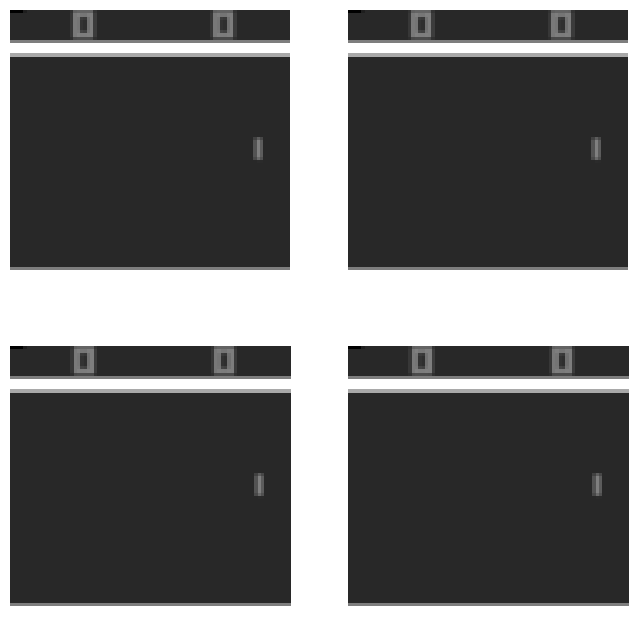

In [4]:
# env = gym_super_mario_bros.make("SuperMarioBros-1-1-v3", render_mode='rgb', apply_api_compatibility=True)
env = gym.make("ALE/Pong-v5", render_mode='rgb_array', apply_api_compatibility=False)
# Change action-space. 
# env = JoypadSpace(env, [["right"], ["right", "A"]])

obs, _ = env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
print(f"{next_state.shape},\n {reward},\n {done},\n {info}")
print("============================")

# Apply Wrappers to environment
skip_frames = 4
# env = SkipFrame(env, skip=skip_frames)
env = gym.make("ALE/Pong-v5", render_mode='rgb_array', apply_api_compatibility=False)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=skip_frames)
env.reset()

for _ in range(10):
    next_state, reward, done, trunc, info = env.step(action=0)

figure = plt.figure(figsize=(8, 8))
cols, rows = 2, 2
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    
    # RGB channels
    plt.imshow(next_state[i - 1].squeeze(), cmap = "gray")
    
plt.show()

In [5]:
# Model Definition 

info = dict(
    state_dim = (4, 84, 84),
    action_dim = env.action_space.n,
    save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S"),
    batch_size = 128,
#     burnin = 1000, 
#     sync_every = 100,
#     learn_every = 1
)

net = DoubleQCNN(info["state_dim"], info["action_dim"])
model = TDWrapper(net, info)

logger = MetricLogger(info["save_dir"])

In [6]:
episodes = 1500
for e in range(episodes):
    state = env.reset()
    while True:
        action = model.act(state)
        next_state, reward, done, trunc, info = env.step(action)
        model.cache(state, next_state, action, reward, done)
        q, loss = model.learn()

        # Logging
        logger.log_step(reward, loss, q)

        # Update state
        state = next_state

        # Check if end of game
        if done: #or info["flag_get"]:
            break

    logger.log_episode()

    if e % 20 == 0:
        logger.record(episode=e, epsilon=model.exploration_rate, step=model.curr_step)

Episode 0 - Step 993 - Epsilon 0.9997517807804224 - Mean Reward -20.0 - Mean Length 993.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 1.261 - Time 2023-05-02T22:54:51
Episode 20 - Step 19146 - Epsilon 0.9952249364399338 - Mean Reward -20.476 - Mean Length 911.714 - Mean Loss 0.006 - Mean Q Value -0.01 - Time Delta 32.816 - Time 2023-05-02T22:55:24
Episode 40 - Step 36838 - Epsilon 0.990832776418598 - Mean Reward -20.561 - Mean Length 898.488 - Mean Loss 0.008 - Mean Q Value -0.032 - Time Delta 49.362 - Time 2023-05-02T22:56:13
Episode 60 - Step 55252 - Epsilon 0.9862819600412824 - Mean Reward -20.508 - Mean Length 905.77 - Mean Loss 0.009 - Mean Q Value -0.046 - Time Delta 51.325 - Time 2023-05-02T22:57:05
Episode 80 - Step 74145 - Epsilon 0.9816344874195412 - Mean Reward -20.42 - Mean Length 915.37 - Mean Loss 0.01 - Mean Q Value -0.059 - Time Delta 53.075 - Time 2023-05-02T22:57:58
Episode 100 - Step 92179 - Epsilon 0.9772187494375055 - Mean Reward -20.43 - Mean Length 911.86 - M

Episode 900 - Step 822192 - Epsilon 0.814200991037531 - Mean Reward -20.37 - Mean Length 910.52 - Mean Loss 0.011 - Mean Q Value -0.212 - Time Delta 75.426 - Time 2023-05-02T23:36:14
Episode 920 - Step 840350 - Epsilon 0.8105133016429487 - Mean Reward -20.37 - Mean Length 909.38 - Mean Loss 0.011 - Mean Q Value -0.211 - Time Delta 69.035 - Time 2023-05-02T23:37:24
Episode 940 - Step 857493 - Epsilon 0.8070470768187202 - Mean Reward -20.42 - Mean Length 897.24 - Mean Loss 0.011 - Mean Q Value -0.21 - Time Delta 50.608 - Time 2023-05-02T23:38:14
Episode 960 - Step 875824 - Epsilon 0.8033570430747822 - Mean Reward -20.34 - Mean Length 899.18 - Mean Loss 0.012 - Mean Q Value -0.209 - Time Delta 59.497 - Time 2023-05-02T23:39:14
Episode 980 - Step 893145 - Epsilon 0.7998858268457452 - Mean Reward -20.44 - Mean Length 888.68 - Mean Loss 0.012 - Mean Q Value -0.209 - Time Delta 55.327 - Time 2023-05-02T23:40:09
Episode 1000 - Step 910758 - Epsilon 0.7963714721083472 - Mean Reward -20.49 - Mea

<Figure size 640x480 with 0 Axes>

In [10]:

render_env = gym.make("ALE/Pong-v5", render_mode='human', apply_api_compatibility=False)
render_env = GrayScaleObservation(render_env)
render_env = ResizeObservation(render_env, shape=84)
render_env = FrameStack(render_env, num_stack=skip_frames)
render_env.reset()

state = render_env.reset()
total_reward = 0
while True:
    action = model.act(state)
    next_state, reward, done, trunc, info = render_env.step(action)
    state = next_state
    # Check if end of game
    if done: #or info["flag_get"]:
        break

render_env.close()

LukeJuusola change made in gymnasium.wrappers.gray_scale_observation.py:
